In [1]:
import os 
os.environ['CUDA_VISIBLE_DEVICES'] = '1'

In [2]:
%reload_ext autoreload
%autoreload 2

In [3]:
import copy
import torch
import torch.nn as nn
import torch_geometric.transforms as T
import matplotlib.pyplot as plt

from torch_geometric.datasets import Planetoid
from torch_geometric.nn import GCNConv, PairNorm, MessagePassing
from torch_geometric.utils import add_self_loops, degree, dropout_edge


from funcs import *
from models import *

# Get Dataset

In [4]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)
transform = T.Compose([
    T.NormalizeFeatures(),
    T.ToDevice(device),
])
dataset = Planetoid(root='CORA/', name='Cora', transform=transform)

cuda


In [5]:
print(dataset[0].train_mask.sum())
print(dataset[0].val_mask.sum())
print(dataset[0].test_mask.sum())

tensor(140, device='cuda:0')
tensor(500, device='cuda:0')
tensor(1000, device='cuda:0')


# Default Settings

In [6]:
in_channels = dataset[0].num_node_features
train_losses, train_accs, valid_losses, valid_accs = train_valid_node(
    GCN4NODE(in_channels=in_channels, n_layers=2, pair_norm=False, activation="relu", add_self_loops=True, drop_edge=0.1), 
    dataset[0], n_epochs=200, verbose=True)

epcoh [10], train loss: [1.1593], train accuracy: [0.7929]
epcoh [10], valid loss: [1.3017], valid accuracy: [0.7300]
epcoh [20], train loss: [0.6571], train accuracy: [0.8286]
epcoh [20], valid loss: [0.9479], valid accuracy: [0.7320]
epcoh [30], train loss: [0.4997], train accuracy: [0.9071]
epcoh [30], valid loss: [0.8442], valid accuracy: [0.7780]
epcoh [40], train loss: [0.2975], train accuracy: [0.9571]
epcoh [40], valid loss: [0.7631], valid accuracy: [0.7680]
epcoh [50], train loss: [0.2520], train accuracy: [0.9857]
epcoh [50], valid loss: [0.7448], valid accuracy: [0.7800]
epcoh [60], train loss: [0.2649], train accuracy: [0.9571]
epcoh [60], valid loss: [0.7660], valid accuracy: [0.7660]
epcoh [70], train loss: [0.2557], train accuracy: [0.9571]
epcoh [70], valid loss: [0.7536], valid accuracy: [0.7720]
epcoh [80], train loss: [0.2251], train accuracy: [0.9857]
epcoh [80], valid loss: [0.7620], valid accuracy: [0.7840]
epcoh [90], train loss: [0.2575], train accuracy: [0.971

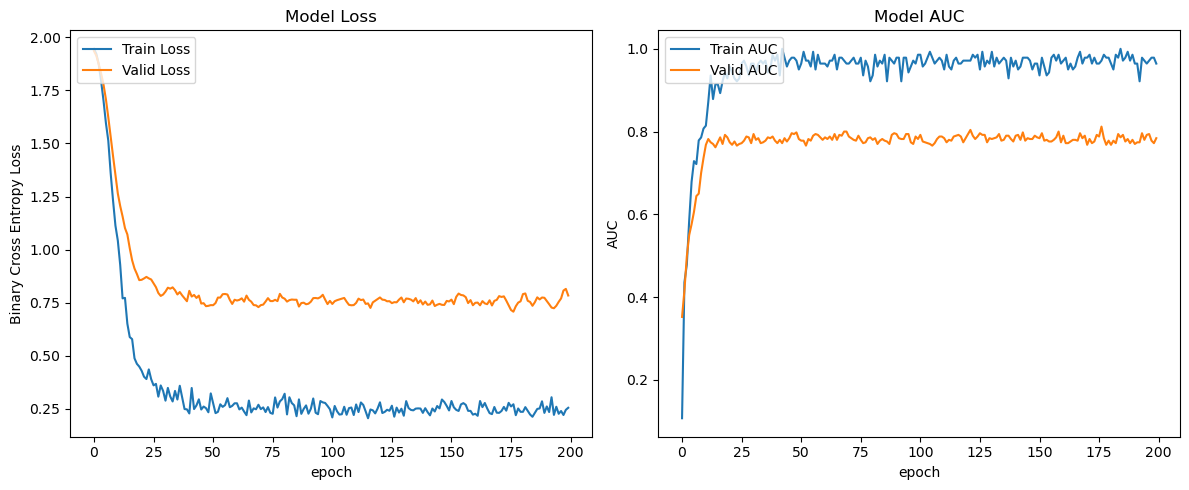

In [53]:
show_process_link(train_losses, train_accs, valid_losses, valid_accs)

# Tune

In [30]:
loops = [True, False]
layers = [1, 2, 3, 4, 5]
drop_edges = [0, 0.1, 0.2, 0.3, 0.5]
pair_norms = [True, False]
activations = ["relu", "leaky_relu", "tanh", "sigmoid"]

best_loop = True
best_layer = 2
best_drop_edge = 0.2
best_pair_norm = False
best_activation = "tanh"
best_acc = 0

in_channels = dataset[0].num_node_features
for loop in loops:
    for layer in layers:
        for drop_edge in drop_edges:
            for pair_norm in pair_norms:
                for activation in activations:
                    print("loop: {}, layer: {}, drop_edge: {}, pair_norm: {}, activation: {}".format(loop, layer, drop_edge, pair_norm, activation))
                    train_losses, train_accs, valid_losses, valid_accs = train_valid_node(
                        GCN4NODE(in_channels=in_channels, n_layers= layer, 
                            pair_norm=pair_norm, activation=activation, 
                            add_self_loops=loop, drop_edge=drop_edge), 
                        dataset[0], n_epochs=200, verbose=False)
                    acc = sum(valid_accs[-50:]) / 50
                    if acc > best_acc:
                        best_acc =  acc
                        best_loop = loop
                        best_layer = layer
                        best_drop_edge = drop_edge
                        best_pair_norm = pair_norm
                        best_activation = activation

loop: True, layer: 1, drop_edge: 0, pair_norm: True, activation: relu
epcoh [200], train loss: [0.3596], train accuracy: [0.9929]
epcoh [200], valid loss: [1.8214], valid accuracy: [0.3320]
loop: True, layer: 1, drop_edge: 0, pair_norm: True, activation: leaky_relu
epcoh [200], train loss: [0.2991], train accuracy: [1.0000]
epcoh [200], valid loss: [1.8195], valid accuracy: [0.3280]
loop: True, layer: 1, drop_edge: 0, pair_norm: True, activation: tanh
epcoh [200], train loss: [0.7838], train accuracy: [1.0000]
epcoh [200], valid loss: [1.8193], valid accuracy: [0.3820]
loop: True, layer: 1, drop_edge: 0, pair_norm: True, activation: sigmoid
epcoh [200], train loss: [1.4816], train accuracy: [1.0000]
epcoh [200], valid loss: [1.9175], valid accuracy: [0.2840]
loop: True, layer: 1, drop_edge: 0, pair_norm: False, activation: relu
epcoh [200], train loss: [1.4462], train accuracy: [0.9286]
epcoh [200], valid loss: [1.6831], valid accuracy: [0.6940]
loop: True, layer: 1, drop_edge: 0, pair

In [43]:
print("acc: {}, loop: {}, layer: {}, drop_edge: {}, pair_norm: {}, activation: {}"
      .format(best_acc, best_loop, best_layer, best_drop_edge, best_pair_norm, best_activation))

acc: 0.7923199999999997, loop: False, layer: 2, drop_edge: 0, pair_norm: False, activation: relu


In [46]:
in_channels = dataset[0].num_node_features
train_losses, train_accs, valid_losses, valid_accs = train_valid_node(
    GCN4NODE(in_channels=in_channels, n_layers= best_layer, pair_norm=best_pair_norm, 
        activation=best_activation, add_self_loops=best_loop, drop_edge=best_drop_edge), 
    dataset[0], n_epochs=200, verbose=True)

epcoh [10], train loss: [1.6527], train accuracy: [0.6071]
epcoh [10], valid loss: [1.7316], valid accuracy: [0.5380]
epcoh [20], train loss: [1.0916], train accuracy: [0.6571]
epcoh [20], valid loss: [1.3699], valid accuracy: [0.5640]
epcoh [30], train loss: [1.0315], train accuracy: [0.6143]
epcoh [30], valid loss: [1.2676], valid accuracy: [0.5800]
epcoh [40], train loss: [0.8892], train accuracy: [0.7429]
epcoh [40], valid loss: [1.1440], valid accuracy: [0.7000]
epcoh [50], train loss: [0.7510], train accuracy: [0.7857]
epcoh [50], valid loss: [0.9875], valid accuracy: [0.7300]
epcoh [60], train loss: [0.6621], train accuracy: [0.7857]
epcoh [60], valid loss: [0.9786], valid accuracy: [0.7100]
epcoh [70], train loss: [0.6286], train accuracy: [0.8000]
epcoh [70], valid loss: [0.9517], valid accuracy: [0.7140]
epcoh [80], train loss: [0.5652], train accuracy: [0.8214]
epcoh [80], valid loss: [0.9169], valid accuracy: [0.7260]
epcoh [90], train loss: [0.5217], train accuracy: [0.828

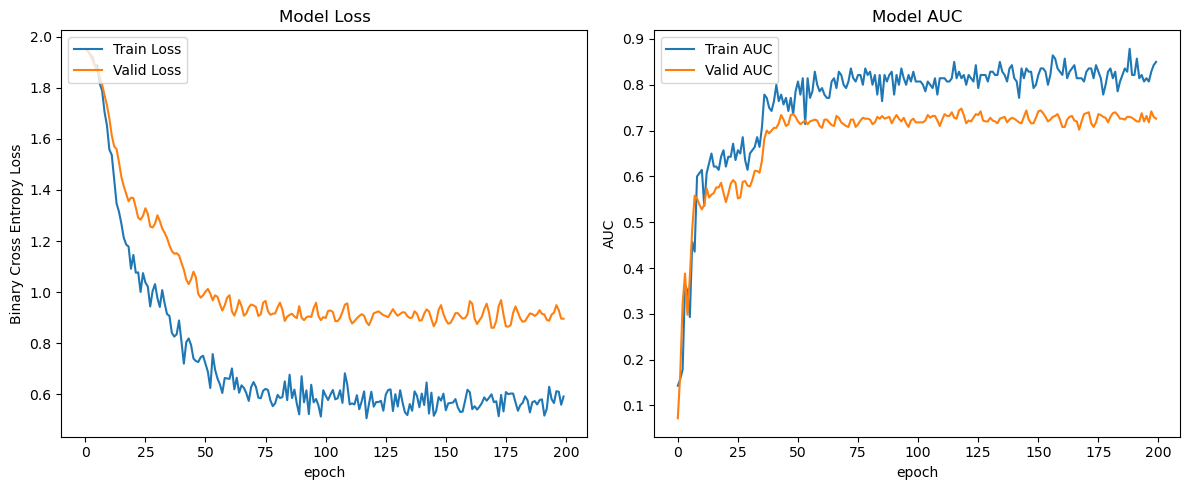

In [47]:
show_process_link(train_losses, train_accs, valid_losses, valid_accs)

# Train and Test

In [124]:
best_loop = True
best_layer = 2
best_drop_edge = 0
best_pair_norm = False
best_activation = "tanh"

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = GCN4NODE(in_channels=in_channels, n_layers= best_layer, 
            pair_norm=best_pair_norm, activation=best_activation, 
            add_self_loops=best_loop, drop_edge=best_drop_edge).to(device)
dataset1 = dataset[0].to(device)
n_epochs = 200

optimizer = torch.optim.Adam(model.parameters(), lr=0.1, weight_decay=5e-4)
criterion = nn.CrossEntropyLoss()

train_losses = []
train_accs = []

mask = dataset1.train_mask | dataset1.val_mask

for epoch in range(1, n_epochs + 1):
    model.train()
    optimizer.zero_grad()
    pred = model(dataset1.x, dataset1.edge_index)
    train_loss = criterion(pred[mask], dataset1.y[mask])
    train_loss.backward()
    optimizer.step()
    pred_label = pred.argmax(dim=1)
    train_correct = (pred_label[mask] == dataset1.y[mask]).sum()
    train_acc = int(train_correct) / int(mask.sum())
    if epoch % 10 == 0:
        print("epcoh [%d], train loss: [%.4f], train accuracy: [%.4f]" %(epoch, train_loss, train_acc))

    train_losses.append(train_loss.item())
    train_accs.append(train_acc)

model.eval()
with torch.no_grad():
    pred = model(dataset1.x, dataset1.edge_index)
    test_loss = criterion(pred[dataset1.test_mask], dataset1.y[dataset1.test_mask]).item()
    pred_label = pred.argmax(dim=1)
    test_correct = (pred_label[dataset1.test_mask] == dataset1.y[dataset1.test_mask]).sum()
    test_acc = int(test_correct) / int(dataset1.test_mask.sum())
    print("\ntest loss: [%.4f], test accuracy: [%.4f]" %(test_loss, test_acc))

epcoh [10], train loss: [1.2295], train accuracy: [0.8109]
epcoh [20], train loss: [1.0093], train accuracy: [0.8844]
epcoh [30], train loss: [0.9394], train accuracy: [0.9250]
epcoh [40], train loss: [0.9095], train accuracy: [0.9328]
epcoh [50], train loss: [0.9067], train accuracy: [0.9281]
epcoh [60], train loss: [0.9142], train accuracy: [0.9172]
epcoh [70], train loss: [0.9228], train accuracy: [0.9156]
epcoh [80], train loss: [0.9085], train accuracy: [0.9391]
epcoh [90], train loss: [0.9110], train accuracy: [0.9250]
epcoh [100], train loss: [0.9167], train accuracy: [0.9391]
epcoh [110], train loss: [0.9259], train accuracy: [0.9250]
epcoh [120], train loss: [0.9104], train accuracy: [0.9375]
epcoh [130], train loss: [0.9337], train accuracy: [0.9250]
epcoh [140], train loss: [0.9163], train accuracy: [0.9266]
epcoh [150], train loss: [0.9108], train accuracy: [0.9203]
epcoh [160], train loss: [0.9052], train accuracy: [0.9266]
epcoh [170], train loss: [0.9027], train accuracy

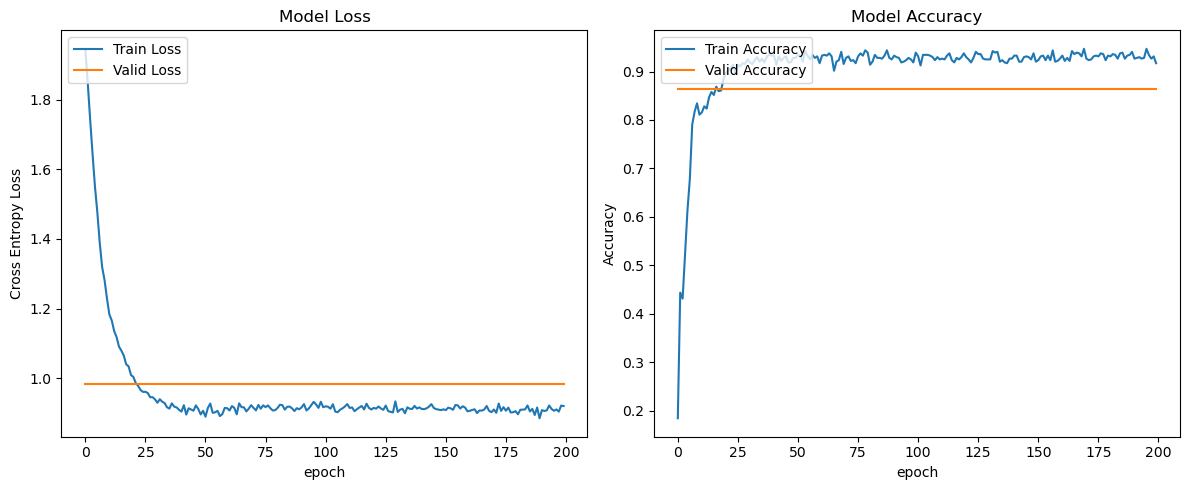

In [125]:
test_losses = [test_loss for _ in range(n_epochs)]
test_accs = [test_acc for _ in range(n_epochs)]
show_process_node(train_losses, train_accs, test_losses, test_accs)